In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import shap
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

d:\WORKSPACE_CS\LJMU_Research\other\dash\health_policy_recomendation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [157]:
# Load dataset
df = pd.read_csv("D:/WORKSPACE_CS/LJMU_Research/other/dash/health_policy_recomendation/src/health_policy_recomendation/data/ushealthinsurance_with_company3.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                1338 non-null   int64  
 1   sex                1338 non-null   object 
 2   bmi                1338 non-null   float64
 3   children           1338 non-null   int64  
 4   smoker             1338 non-null   object 
 5   region             1338 non-null   object 
 6   charges            1338 non-null   float64
 7   insurance_company  1338 non-null   object 
dtypes: float64(2), int64(2), object(4)
memory usage: 83.8+ KB


In [158]:
df.head()

,age,sex,bmi,children,smoker,region,charges,insurance_company
0,19,female,27.900,0,yes,southwest,16884.92400,Company C
1,18,male,33.770,1,no,southeast,1725.55230,Company D
2,28,male,33.000,3,no,southeast,4449.46200,Company D
3,33,male,22.705,0,no,northwest,21984.47061,Company C
4,32,male,28.880,0,no,northwest,3866.85520,Company D


In [4]:
df['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

In [5]:
df['insurance_company'].value_counts(normalize=True)

insurance_company
Company D    0.415546
Company A    0.336323
Company C    0.132287
Company B    0.115845
Name: proportion, dtype: float64

In [6]:
# Convert categorical columns to numerical
le = LabelEncoder()
df['insurance_company'] = le.fit_transform(df['insurance_company'])

In [7]:
q1 = df['charges'].quantile(0.25)
q3 = df['charges'].quantile(0.75)

df['budget'] = pd.cut(
    df['charges'],
    bins=[-float('inf'), q1, q3, float('inf')],
    labels=['low', 'medium', 'high']
)

df['budget'] = df['budget'].astype('object')

In [11]:
# Map budget to score
budget_score = df['budget'].map({'low': 5, 'medium': 3, 'high': 1})

# Compute feedback
df['feedback'] = (
    budget_score + 
    df['smoker'].map({'yes': -1, 'no': 1}) + 
    df['bmi'].apply(lambda x: 1 if x < 25 else -1)
)

# Clip to range 0–5
df['feedback'] = df['feedback'].clip(0, 5)

In [14]:
def health_score(row):
    score = 2
    if row['bmi'] < 25:
        score += 1
    elif row['bmi'] >= 30:
        score -= 1

    score += 1 if row['smoker'] == 'no' else -1
    return score

df['health_score'] = df.apply(health_score, axis=1)

health score (from BMI + smoker)  
```
BMI | Smoker | Final Score
≥30 | Yes | 0
25–29.9 | No | 3
<25 | No | 4
```

In [ ]:
# TBD features

df['age_group'] = pd.cut(
    df['age'], 
    bins=[17, 25, 35, 45, 55, 65], 
    labels=['18-25', '26-35', '36-45', '46-55', '56-65']
)
df = pd.get_dummies(df, columns=['age_group'])

In [ ]:
# TBD features
df['bmi_group'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, 35, 100], labels=['underweight', 'normal', 'overweight', 'obese', 'extreme'])

In [15]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'insurance_company', 'budget', 'feedback', 'health_score'],
      dtype='object')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                1338 non-null   int64  
 1   sex                1338 non-null   object 
 2   bmi                1338 non-null   float64
 3   children           1338 non-null   int64  
 4   smoker             1338 non-null   object 
 5   region             1338 non-null   object 
 6   charges            1338 non-null   float64
 7   insurance_company  1338 non-null   int32  
 8   budget             1338 non-null   object 
 9   feedback           1338 non-null   int64  
 10  health_score       1338 non-null   int64  
dtypes: float64(2), int32(1), int64(4), object(4)
memory usage: 109.9+ KB


In [17]:
df.describe()

,age,bmi,children,charges,insurance_company,feedback,health_score
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265,1.627055,3.005232,2.245142
std,14.049960,6.098187,1.205493,12110.011237,1.318671,1.758612,1.109419
min,18.000000,15.960000,0.000000,1121.873900,0.000000,0.000000,0.000000
25%,27.000000,26.296250,0.000000,4740.287150,0.000000,3.000000,2.000000
50%,39.000000,30.400000,1.000000,9382.033000,2.000000,3.000000,2.000000
75%,51.000000,34.693750,2.000000,16639.912515,3.000000,5.000000,3.000000
max,64.000000,53.130000,5.000000,63770.428010,3.000000,5.000000,4.000000


In [18]:
df['feedback'].describe()

count    1338.000000
mean        3.005232
std         1.758612
min         0.000000
25%         3.000000
50%         3.000000
75%         5.000000
max         5.000000
Name: feedback, dtype: float64

In [19]:
# We will not be using column 'charges'
df.drop(columns=['charges'], inplace=True)

In [20]:
df.isnull().sum()

age                  0
sex                  0
bmi                  0
children             0
smoker               0
region               0
insurance_company    0
budget               0
feedback             0
health_score         0
dtype: int64

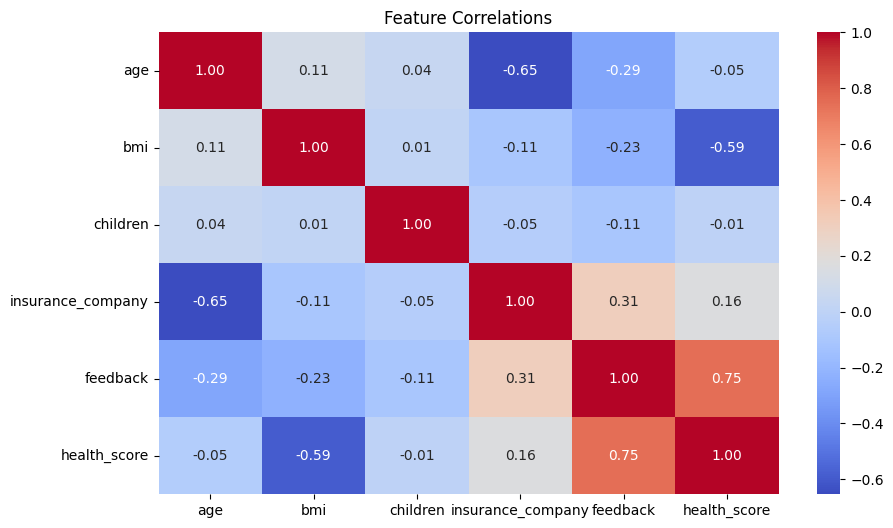

In [21]:
# Compute correlation matrix
correlation_matrix = df.select_dtypes(include=np.number).corr()

# Heatmap for visualization
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlations")
plt.show()

In [22]:
from imblearn.over_sampling import SMOTE

# Step 3: Drop original charges column
X = df.drop(['insurance_company'], axis=1)

X_encoded = pd.get_dummies(X, columns=['sex','smoker','region', 'budget'], drop_first=True)


# Step 5: Train classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

y = df['insurance_company']
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.20, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train on balanced data
rf.fit(X_resampled, y_resampled)

# rf.fit(X_train, y_train)

# Evaluate
accuracy = rf.score(X_test, y_test)
print(f"Model accuracy: {accuracy:.4f}")

Model accuracy: 0.9776


In [23]:
model_features = X_encoded.columns.tolist()

In [24]:
y_pred = rf.predict(X_test)

In [25]:
print(accuracy_score(y_test, y_pred))

0.9776119402985075


In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        90
           1       1.00      1.00      1.00        31
           2       1.00      1.00      1.00        36
           3       0.96      0.98      0.97       111

    accuracy                           0.98       268
   macro avg       0.99      0.98      0.98       268
weighted avg       0.98      0.98      0.98       268



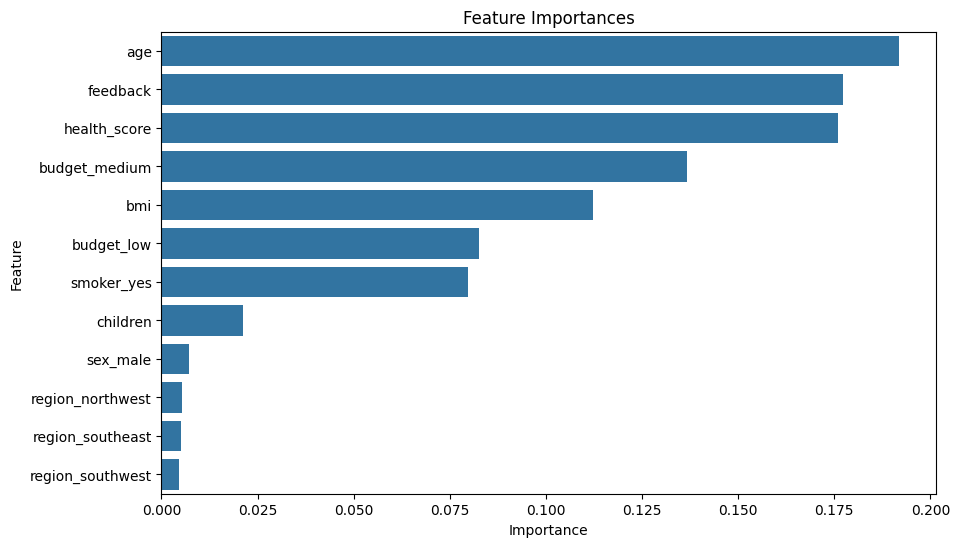

In [27]:
# Feature importance

importances = rf.feature_importances_

# Create a DataFrame for feature importances

importances_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [29]:
importances_df

,Feature,Importance
0,age,0.191966
3,feedback,0.177156
4,health_score,0.175934
11,budget_medium,0.136672
1,bmi,0.112308
10,budget_low,0.082647
6,smoker_yes,0.079679
2,children,0.021322
5,sex_male,0.007169
7,region_northwest,0.005473


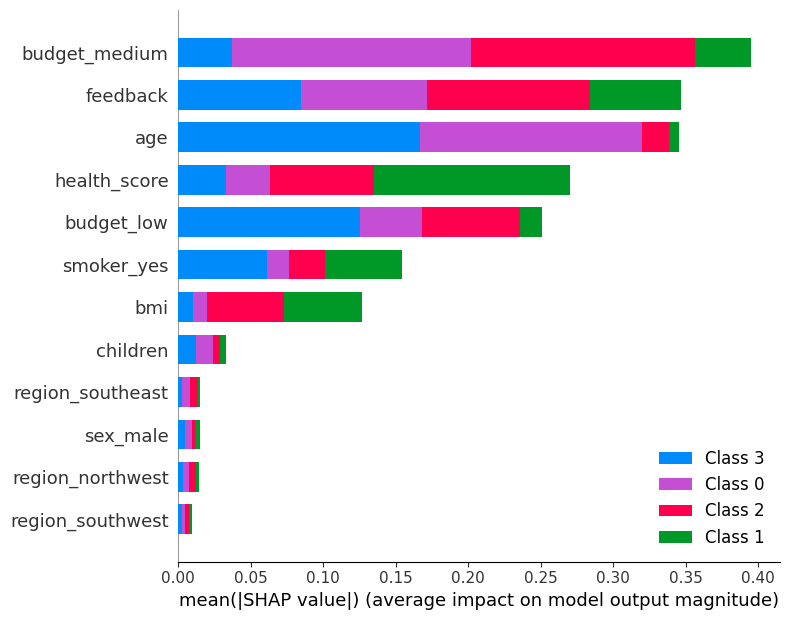

In [30]:
explainer = shap.TreeExplainer(rf)
# Compute SHAP values
shap_values = explainer(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test)

#### Trying out different models

In [37]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 332
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 12
[LightGBM] [Info] Start training from score -1.089310
[LightGBM] [Info] Start training from score -2.155132
[LightGBM] [Info] Start training from score -2.026654
[LightGBM] [Info] Start training from score -0.877340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

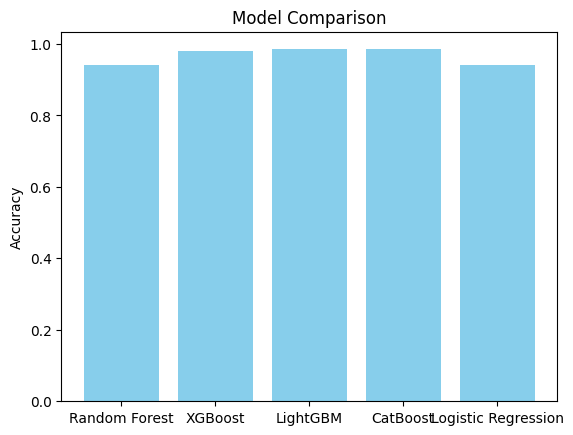

In [43]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(max_depth=4, random_state=42),
    "CatBoost": CatBoostClassifier(depth=4, iterations=100,  random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=100, random_state=42),
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    # print(f"\n{name} Accuracy: {acc:.4f}")
    # print(classification_report(y_test, y_pred))

# Show comparison
plt.bar(results.keys(), results.values(), color='skyblue')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()

In [39]:
results

{'Random Forest': 0.9402985074626866,
 'XGBoost': 0.9813432835820896,
 'LightGBM': 0.9850746268656716,
 'CatBoost': 0.9850746268656716,
 'Logistic Regression': 0.9402985074626866}

In [46]:
cbm = CatBoostClassifier(depth=4, iterations=100,  random_state=42)

# Apply SMOTE to balance classes
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# # Train on balanced data
# cbm.fit(X_resampled, y_resampled, verbose=False)

cbm.fit(X_train, y_train, verbose=False)

y_pred = cbm.predict(X_test)

In [55]:
from sklearn.metrics import accuracy_score, classification_report

In [56]:
print(accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

0.9850746268656716
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        90
           1       1.00      1.00      1.00        31
           2       1.00      1.00      1.00        36
           3       0.97      0.99      0.98       111

    accuracy                           0.99       268
   macro avg       0.99      0.99      0.99       268
weighted avg       0.99      0.99      0.99       268



In [59]:
# Save the model
import joblib

# Assuming you've already trained your model
cbm.save_model('d:\\WORKSPACE_CS\\LJMU_Research\\other\\dash\\health_policy_recomendation\\src\\health_policy_recomendation\\models\\insurance_model.cbm')
# joblib.dump(rf, 'd:\\WORKSPACE_CS\\LJMU_Research\\other\\dash\\health_policy_recomendation\\src\\health_policy_recomendation\\models\\insurance_model.pkl')
joblib.dump(le, 'd:\\WORKSPACE_CS\\LJMU_Research\\other\\dash\\health_policy_recomendation\\src\\health_policy_recomendation\\models\\label_encoder.pkl')
joblib.dump(model_features, 'd:\\WORKSPACE_CS\\LJMU_Research\\other\\dash\\health_policy_recomendation\\src\\health_policy_recomendation\\models\\model_features.pkl')

['d:\\WORKSPACE_CS\\LJMU_Research\\other\\dash\\health_policy_recomendation\\src\\health_policy_recomendation\\models\\model_features.pkl']

In [61]:
# load model

from catboost import CatBoost

loaded_model = CatBoost()
loaded_model.load_model('d:\\WORKSPACE_CS\\LJMU_Research\\other\\dash\\health_policy_recomendation\\src\\health_policy_recomendation\\models\\insurance_model.cbm')

#### Experiment of utility adjusted ranking

In [146]:
# Basic (Static Preferences)

def get_utility_scores_for_user(user_input_df):
    # Example static mapping (normally you'd fetch this from user profile/preferences)
    preferred_region = user_input_df.iloc[0]["preferred_region"]
    budget_level = user_input_df.iloc[0]["budget_level"]  # low / medium / high

    # Define utility rules for companies (this could come from a config or DB)
    company_meta = {
        "Company A": {"region": "northwest", "price": "medium"},
        "Company B": {"region": "southeast", "price": "low"},
        "Company C": {"region": "southwest", "price": "high"},
        "Company D": {"region": "northeast", "price": "medium"},
    }

    utility_scores = {}

    for company, meta in company_meta.items():
        score = 1.0  # base utility

        # Increase utility if region matches
        if meta["region"] == preferred_region:
            score += 0.3

        # Modify based on budget match
        if meta["price"] == budget_level:
            score += 0.2

        utility_scores[company] = score

    return utility_scores


In [ ]:
# Data-Driven Utility Scores
def get_utility_scores_for_user(user_input_df):
    # Extract user ID or identifying info (if available)
    user_id = user_input_df.iloc[0]["user_id"]

    # Simulated past feedback (in production, fetch from DB or logs)
    past_user_feedback = {
        "Company_A": 5,  # 5-star rating from this user
        "Company_B": 2,
        "Company_C": 4,
        "Company_D": 0,  # No feedback or bad experience
    }

    # Normalize feedback into a utility score (scale 0.0 to 1.0)
    max_rating = 5
    utility_scores = {
        company: rating / max_rating for company, rating in past_user_feedback.items()
    }

    # Default score for unseen companies
    all_companies = ["Company_A", "Company_B", "Company_C", "Company_D", "Company_E"]
    for company in all_companies:
        if company not in utility_scores:
            utility_scores[company] = 0.5  # Neutral utility

    return utility_scores


In [71]:
model_features

['age',
 'bmi',
 'children',
 'feedback',
 'health_score',
 'sex_male',
 'smoker_yes',
 'region_northwest',
 'region_southeast',
 'region_southwest',
 'budget_low',
 'budget_medium']

In [ ]:
['age', 'bmi', 'children', 'feedback', 'health_score', 'sex_male',
       'smoker_yes', 'region_northwest', 'region_southeast',
       'region_southwest', 'budget_low', 'budget_medium']

In [96]:
def preprocess_user_input(user_input_df, model_features):
    # One-hot encode like training
    user_input_encoded = pd.get_dummies(user_input_df, columns=['sex', 'smoker', 'region', 'budget'], drop_first=True)

    # Add missing columns that existed during training
    for col in model_features:
        if col not in user_input_encoded.columns:
            user_input_encoded[col] = 0

    # Reorder to match model input exactly
    user_input_encoded = user_input_encoded[model_features]

    return user_input_encoded


In [153]:
def health_score(row):
    score = 2
    if row['bmi'] < 25:
        score += 1
    elif row['bmi'] >= 30:
        score -= 1

    score += 1 if row['smoker'] == 'no' else -1
    return score


def recommend_for_user(user_input_df, rf_model, features, get_utility_scores_for_user, top_n=3):

    # Map budget to score
    budget_score = user_input_df['budget'].map({'low': 5, 'medium': 3, 'high': 1})

    # Compute feedback
    user_input_df['feedback'] = (
        budget_score + 
        user_input_df['smoker'].map({'yes': -1, 'no': 1}) + 
        user_input_df['bmi'].apply(lambda x: 1 if x < 25 else -1)
    )

    # Clip to range 0–5
    user_input_df['feedback'] = user_input_df['feedback'].clip(0, 5)


    user_input_df['health_score'] = user_input_df.apply(health_score, axis=1)

    # Preprocess user input to match training features
    user_input_encoded = preprocess_user_input(user_input_df, features)

    # Step 1: Predict class probabilities
    probs = rf_model.predict_proba(user_input_encoded)
    
    # Step 2: Get top-N most probable recommendations
    top_n_probs = sorted(
        list(zip(le.inverse_transform(rf_model.classes_), probs[0])),
        key=lambda x: x[1],
        reverse=True
    )[:top_n]
    
    # Step 3: Fetch user-specific utility scores
    utility_scores = get_utility_scores_for_user(user_input_df)
    
    # Step 4: Multiply probabilities with utility scores
    recommendations = [
        (company, prob * utility_scores.get(company, 1.0))  # Default utility = 1.0 if not found
        for company, prob in top_n_probs
    ]
    
    # Step 5: Re-rank based on adjusted utility score
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)
    
    return recommendations


2

In [135]:
le.inverse_transform(rf.classes_)

array(['Company A', 'Company B', 'Company C', 'Company D'], dtype=object)

In [163]:
df.head()

,age,sex,bmi,children,smoker,region,charges,insurance_company
0,19,female,27.900,0,yes,southwest,16884.92400,Company C
1,18,male,33.770,1,no,southeast,1725.55230,Company D
2,28,male,33.000,3,no,southeast,4449.46200,Company D
3,33,male,22.705,0,no,northwest,21984.47061,Company C
4,32,male,28.880,0,no,northwest,3866.85520,Company D


In [83]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region',
       'insurance_company', 'budget', 'feedback', 'health_score'],
      dtype='object')

In [166]:
user_input_df = pd.DataFrame({'age':19, 'sex':'female', 'bmi':27.9, 'children':0, 'smoker':'yes', 'region':'southeast', 'budget':'high', 'preferred_region':'southeast', 'budget_level':'medium'}, index=[0])
# user_input_df = pd.DataFrame({'age':18, 'sex':'male', 'bmi':33.770, 'children':1, 'smoker':'no', 'region':'southeast', 'budget':'low', 'preferred_region':'southeast', 'budget_level':'medium'}, index=[0])

recommendations = recommend_for_user(
    user_input_df,
    rf,
    model_features,
    get_utility_scores_for_user,
    top_n=3
)

recommendations

[('Company C', 0.94),
 ('Company B', 0.026000000000000002),
 ('Company A', 0.024)]

In [89]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
ohe_encoder = ohe.fit_transform(df[['sex', 'smoker', 'region', 'budget']])

In [95]:
user_input_df = pd.DataFrame({'age':19, 'sex':'female', 'bmi':27.9, 'children':0, 'smoker':'yes', 'region':'southeast', 'budget':'medium', 'preferred_region':'southeast', 'budget_level':'medium'}, index=[0])

user_input_df = pd.DataFrame([{
    'sex': 'female',
    'smoker': 'yes',
    'region': 'southeast',
    'budget': 'medium'
}])

# Transform using trained encoder
user_encoded = ohe.transform(user_input_df)
user_encoded

# encoded_dff = pd.get_dummies(user_input_df, columns=['sex', 'smoker', 'region', 'budget'], drop_first=True)
# encoded_dff


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3 stored elements and shape (1, 7)>

In [126]:
le.inverse_transform(np.array([2]))

array(['Company C'], dtype=object)

In [114]:
probs.shape

(268, 4)

In [129]:
probs = rf.predict_proba(X_test)[0]
probs

array([0.98, 0.  , 0.  , 0.02])

In [125]:
top_indices = probs.argsort()[::-1]
top_indices

array([0, 3, 2, 1], dtype=int64)

In [117]:
probs = rf.predict_proba(X_test)[0]
top_indices = probs.argsort()[::-1]
top_company_names = le.inverse_transform(top_indices)
top_company_names

array(['Company A', 'Company D', 'Company C', 'Company B'], dtype=object)

In [19]:
df.head()

,age,sex,bmi,children,smoker,region,charges,insurance_company,feedback,avg_feedback_score
0,19,female,27.900,0,yes,southwest,16884.92400,4,1.676116,3.945307
1,18,male,33.770,1,no,southeast,1725.55230,4,4.864706,3.945307
2,28,male,33.000,3,no,southeast,4449.46200,4,4.651134,3.945307
3,33,male,22.705,0,no,northwest,21984.47061,2,5.000000,4.549802
4,32,male,28.880,0,no,northwest,3866.85520,4,4.696814,3.945307


In [ ]:
df.describe()

In [ ]:
#Step 2: Exploratory Data Analysis (EDA)

In [ ]:
#2.1 Feature Correlations

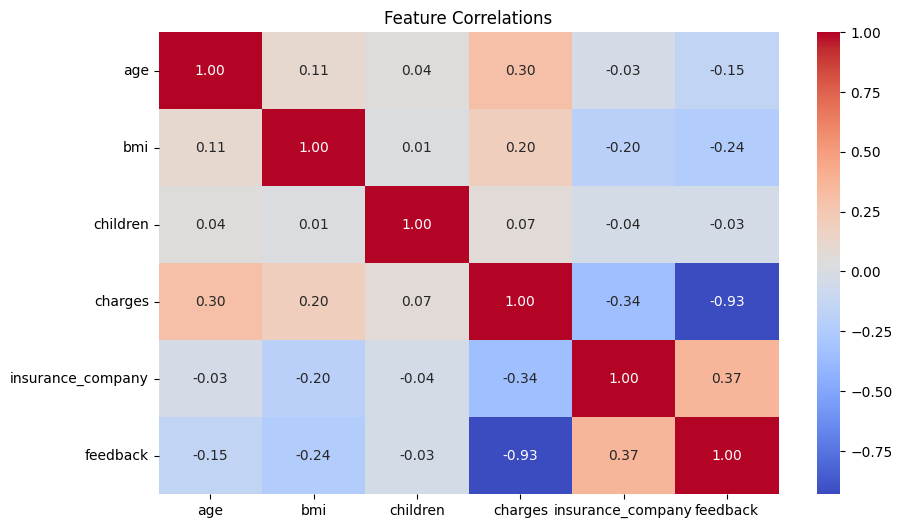

In [17]:
# Compute correlation matrix
correlation_matrix = df.select_dtypes(include=np.number).corr()

# Heatmap for visualization
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlations")
plt.show()

In [ ]:
#Step 3: Data Visualization & Feature Relationships

In [ ]:
#3.1 Age vs Charges

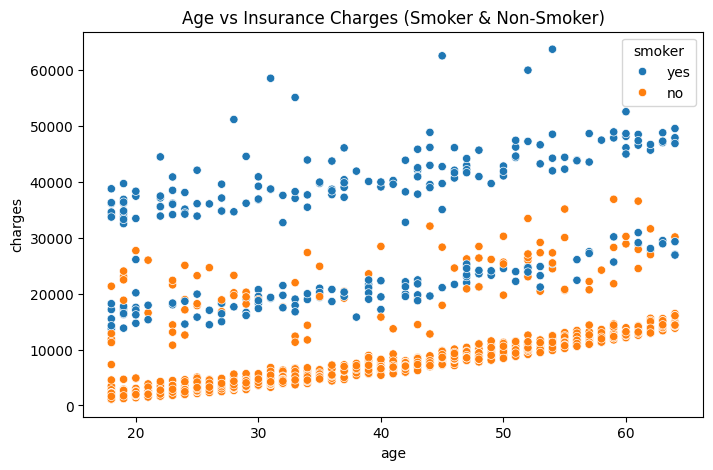

In [17]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["age"], y=df["charges"], hue=df["smoker"])
plt.title("Age vs Insurance Charges (Smoker & Non-Smoker)")
plt.show()

In [ ]:
#3.2 Smoker Impact on Charges

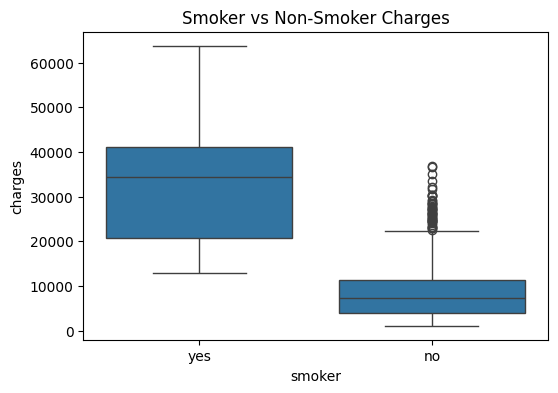

In [18]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["smoker"], y=df["charges"])
plt.title("Smoker vs Non-Smoker Charges")
plt.show()

In [ ]:
#Step 6: Machine Learning Model Training & Selection

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                              n_iter=20, cv=skf, verbose=2, random_state=42, 
                              scoring='accuracy')
rf_random.fit(X, y)
print(f"Best parameters: {rf_random.best_params_}")
print(f"Best accuracy: {rf_random.best_score_:.4f}")

In [ ]:
# Train best model
best_model = rf_random.best_estimator_

# Feature importance
importances = best_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print(feature_importance.head(10))

In [ ]:
#6.1 Split Data

In [ ]:
df.columns

In [ ]:
# Drop unnecessary columns
# X = df.drop(columns=["User ID", "Insurance Company", "feedback_scaled", "charges_scaled"])
X = df[["avg_feedback_score"]]

# Define target variable
y = df["insurance_company"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

# Make predictions

y_pred = rf.predict(X_test)

In [ ]:
# Evaluate the model

from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

In [ ]:
# Feature importance

importances = rf.feature_importances_

# Create a DataFrame for feature importances

importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [17]:
pwd

'd:\\WORKSPACE_CS\\LJMU_Research\\other\\dash\\health_policy_recomendation\\src\\health_policy_recomendation\\notebooks'

In [ ]:
##Train & Evaluate Models
#We will train four models and compare their performances.

In [ ]:
#Visualize Model Performances

In [ ]:
#Step 7: Explainability with SHAP (XAI)

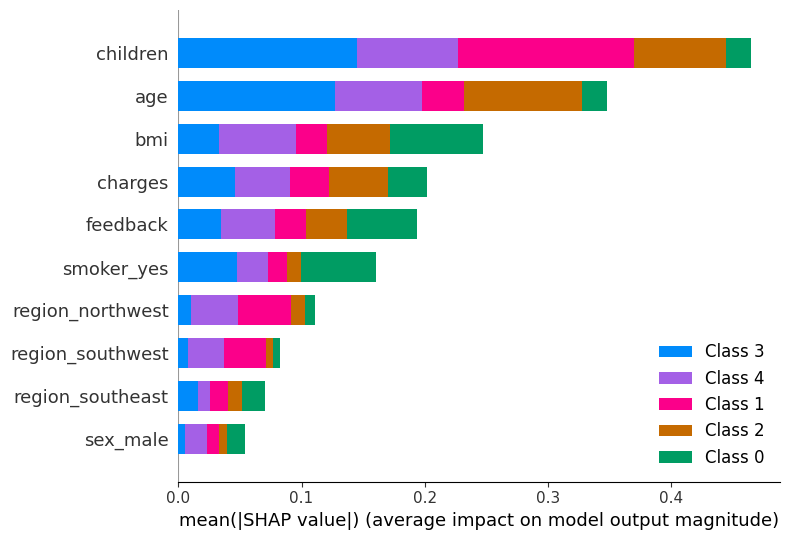

In [15]:
explainer = shap.TreeExplainer(rf)
# Compute SHAP values
shap_values = explainer(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test)

In [ ]:
# Select the best model
final_model = results[best_model]

# Ensure X_train and X_test are in the correct format (SHAP requires raw features)
X_train_shap = pd.DataFrame(scaler.inverse_transform(X_train), columns=X.columns)
X_test_shap = pd.DataFrame(scaler.inverse_transform(X_test), columns=X.columns)

# Choose SHAP explainer based on model type
if best_model in ['Random Forest', 'XGBoost']:
    explainer = shap.TreeExplainer(final_model)  # For tree-based models
elif best_model == 'MLP Regressor':
    explainer = shap.Explainer(final_model, X_train_shap)  # KernelExplainer for NN
else:
    explainer = shap.LinearExplainer(final_model, X_train_shap)  # For linear models

# Compute SHAP values
shap_values = explainer(X_test_shap)

# Summary Plot
shap.summary_plot(shap_values, X_test_shap)



In [ ]:
final_model

In [ ]:
#insurance recommendation_API

In [ ]:
from fastapi import FastAPI, HTTPException
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
import shap
import xgboost as xgb
import lightgbm as lgb

app = FastAPI()

# Load dataset
df = pd.read_csv("augmented_ushealthinsurance.csv")

# Encode categorical variables
label_encoders = {}
categorical_columns = ["sex", "smoker", "region", "Insurance Company", "Feedback"]
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define features and target
X = df.drop(columns=["User ID", "Insurance Company"])
y = df["Insurance Company"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (for SHAP consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# Save models
joblib.dump(rf_model, "rf_model.pkl")
joblib.dump(xgb_model, "xgb_model.pkl")
joblib.dump(lgb_model, "lgb_model.pkl")
joblib.dump(scaler, "scaler.pkl")

# Function to recommend insurance policies
def recommend_insurance(user_input):
    input_df = pd.DataFrame([user_input])

    # Ensure categorical encoding matches training data
    for col, le in label_encoders.items():
        if col in input_df:
            if input_df[col].values[0] in le.classes_:  # Handle unseen categories
                input_df[col] = le.transform(input_df[col])
            else:
                input_df[col] = -1  # Assign unseen categories a default value

    # Drop unnecessary columns
    input_df = input_df.drop(columns=["User ID"], errors='ignore')

    # Scale features
    input_df_scaled = scaler.transform(input_df)

    # Get predictions
    utility_scores = {
        "RandomForest": rf_model.predict_proba(input_df_scaled)[0],
        "XGBoost": xgb_model.predict_proba(input_df_scaled)[0],
        "LightGBM": lgb_model.predict_proba(input_df_scaled)[0],
    }

    # Find best recommendation
    best_model = max(utility_scores, key=lambda k: max(utility_scores[k]))
    best_recommendation = np.argmax(utility_scores[best_model])

    return label_encoders["Insurance Company"].inverse_transform([best_recommendation])[0], best_model

@app.post("/recommend")
def get_recommendation(user_input: dict):
    try:
        recommendation, model_used = recommend_insurance(user_input)
        return {"recommended_insurance": recommendation, "model_used": model_used}
    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

# SHAP Explainability
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_scaled)

@app.get("/explain")
def explain_prediction():
    feature_importance = pd.DataFrame(
        {"Feature": X.columns, "SHAP Value": np.mean(np.abs(shap_values), axis=0)}
    ).sort_values(by="SHAP Value", ascending=False)

    return feature_importance.to_dict(orient="records")


In [ ]:
### or recommendation model/function

In [ ]:
# Function to recommend insurance policies
def recommend_insurance(user_data):
    # Convert user input to DataFrame
    user_df = pd.DataFrame([user_data])

    # --- Apply feedback mapping to the user_df ---
    user_df['Feedback'] = user_df['Feedback'].map(feedback_mapping)

    # Encode categorical columns
    for col in categorical_cols:
        if col in label_encoders:  # Ensure encoder exists
            user_df[col] = user_df[col].map(lambda x: label_encoders[col].classes_.tolist().index(x) if x in label_encoders[col].classes_ else -1)
        else:
            print(f"Warning: {col} was not in the training data!")

    # Normalize numerical columns (ensure correct shape)
    numeric_cols = ['age', 'bmi', 'children', 'charges']
    user_df[numeric_cols] = scaler.transform(user_df[numeric_cols])

    # Calculate utility score
    predicted_utility = calculate_utility(user_df.iloc[0])  # Using existing function

    # Recommend top 3 insurance companies based on highest utility scores
    recommendations = df[['Insurance Company', 'utility_score']].sort_values(by='utility_score', ascending=False).head(3)

    return predicted_utility, recommendations
